#                      <center> Flight Price Analysis </center>
##               <center> Linear Regression and Random Forest Regression</center>


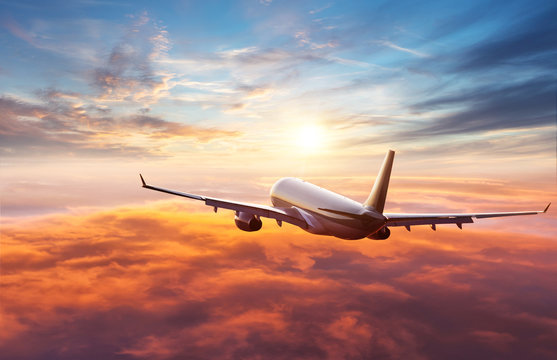

An airline is a company that provides air transport services for traveling passengers and freight.

Airlines assign prices to their services in an attempt to maximize profitability. The pricing of airline tickets has become increasingly complicated over the years and is now largely determined by computerized yield management systems.

The price of an Airline Ticket is affected by a number of factors, such as flight duration, days left for departure, arrival time and departure time etc. Airline organizations may diminish the cost at the time they need to build the market and at the time when the tickets are less accessible. They may maximize the costs. The price may rely upon different factors. Each factor has its own proprietary rules and algorithms to set the price accordingly. Recent advances in Artificial Intelligence (AI) and Machine Learning (ML) makes it possible to infer such rules and model the price variation.

### Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.model_selection import  train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Clean the data and perform EDA

In [2]:
#Read csv
df = pd.read_csv('./Data/Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


##### Clean the Data

In [3]:


#Check number of Null and Nan values and deletes them

num_null = np.sum(df.isnull().astype('int'))
print('Number of Null and Nan values in data frame \n {}'.format(num_null))

df = df[~df.isnull()]

#Remove duplicates

num_duplicated = np.sum(df.duplicated().astype('int'))
print('Number of duplicated elements {}'.format(num_duplicated))

#Rename any columns

df.rename(columns={'Unnamed: 0':'#'} , inplace = True)

#Convert Rupees to Euro

df['price'] = df['price']/89

Number of Null and Nan values in data frame 
 Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64
Number of duplicated elements 0


In [4]:
df.shape

(300153, 12)

In [5]:
#Create 2 DataFrames Economy and Business class

economy_df = df[df['class'] == 'Economy']
business_df = df[df['class'] == 'Business']

#### Perform EDA

                   #       duration      days_left          price
count  206666.000000  206666.000000  206666.000000  206666.000000
mean   103332.500000      11.550060      26.123673      73.846544
std     59659.479704       7.241284      13.529610      42.062017
min         0.000000       0.830000       1.000000      12.415730
25%     51666.250000       6.250000      15.000000      46.887640
50%    103332.500000      10.170000      26.000000      64.853933
75%    154998.750000      15.250000      38.000000      87.033708
max    206665.000000      49.830000      49.000000     475.831461
                   #      duration     days_left         price
count   93487.000000  93487.000000  93487.000000  93487.000000
mean   253409.000000     13.704274     25.741857    590.337990
std     26987.516645      6.852555     13.626538    145.722636
min    206666.000000      1.000000      1.000000    134.831461
25%    230037.500000      8.830000     14.000000    507.696629
50%    253409.000000     13.

<AxesSubplot:xlabel='#', ylabel='price'>

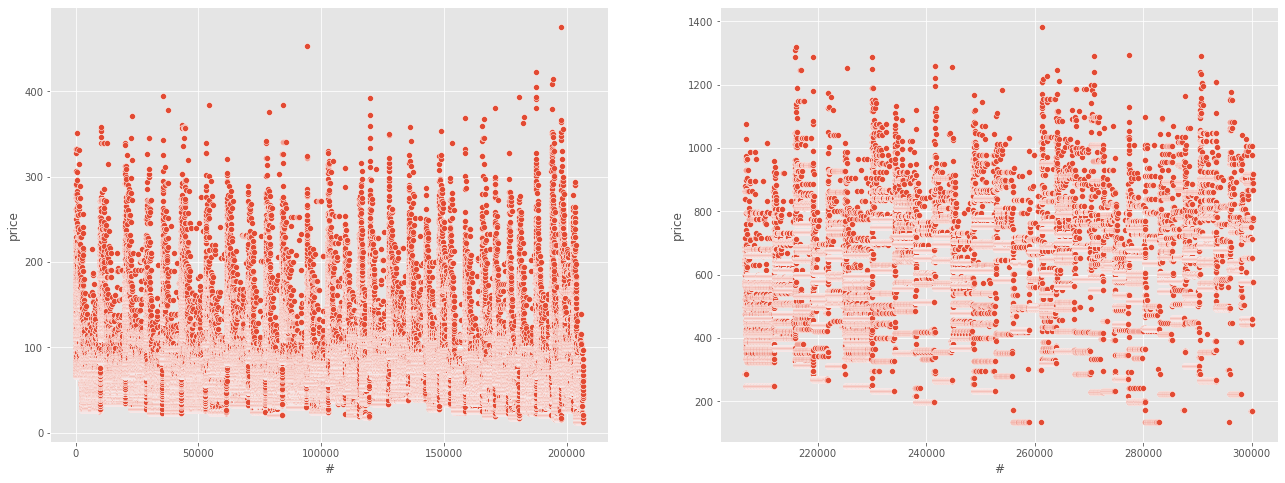

In [6]:

print(economy_df.describe())
print(business_df.describe())

#Add some graphs
fig, ax = plt.subplots(1,2,figsize=(22,8))
sns.scatterplot(data=economy_df, x='#', y='price',ax=ax[0])
sns.scatterplot(data=business_df, x='#', y='price',ax=ax[1])


As we can see from the plot it is very dificult to visualize any trend as the price depends on severall 
factors like destination, days left, airline, duration, etc. 

In [7]:
# Find correlation between values


#First make airlines, destinations stops into numbers
econ_factorized_df = economy_df.copy()
object_columns = economy_df.select_dtypes(include=['object']).columns
for col in object_columns:
    econ_factorized_df[col], _ = pd.factorize(econ_factorized_df[col])
econ_factorized_df = econ_factorized_df.drop(labels='class', axis=1)    

In [8]:
bus_factorized_df = business_df.copy()
object_columns = business_df.select_dtypes(include=['object']).columns
for col in object_columns:
    bus_factorized_df[col], _ = pd.factorize(bus_factorized_df[col])

bus_factorized_df = bus_factorized_df.drop(labels='class', axis=1)

<AxesSubplot:>

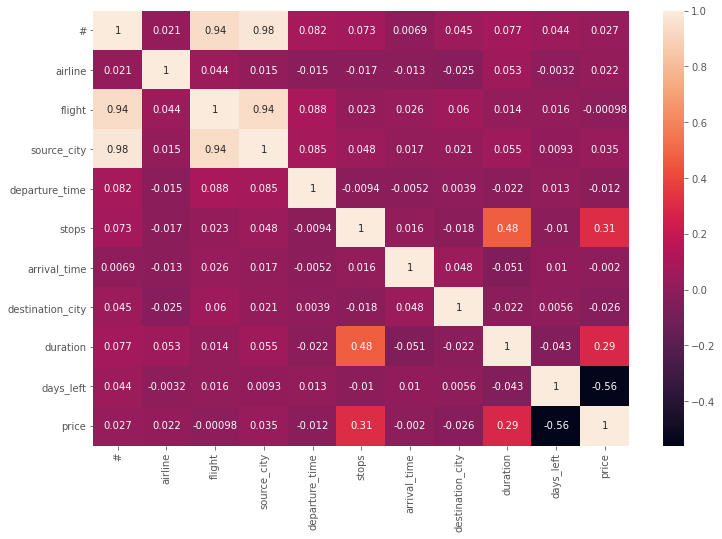

In [9]:
#Plot some graphs

sns.heatmap(econ_factorized_df.corr(), annot=True)

<AxesSubplot:>

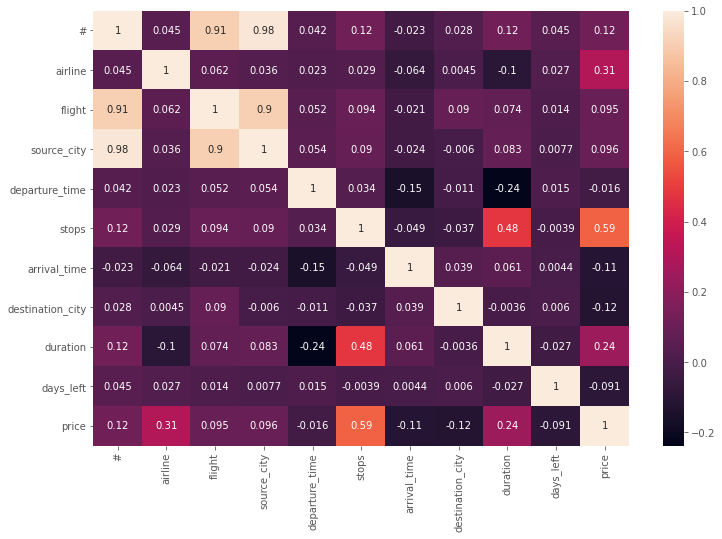

In [10]:
sns.heatmap(bus_factorized_df.corr(), annot=True)

As we can see from the heatmaps the '#' and 'fligth' number column have very high correlation. To avoid problems with the Linear Regression model and the possibility of overfitting in Classification Trees and Random Forests. We are going to eliminate both columns as they do not bring in much information regardless.

In [11]:
econ_factorized_df = econ_factorized_df.drop(['#', 'flight'],axis=1)
bus_factorized_df = bus_factorized_df.drop(['#', 'flight'], axis=1)

- For economy class the most important factors determining a price are: days left, stops and duration.
- For business class the most important factors are: stops, airline and duration.

I would like to point out that it is interesting how Economy class price tickets depend much more on days left than Business class. While on the other hand arilines are a factor in Business class but not in Economy class.<br/>
I am going to continue exploring the features.

Text(0.5, 1.0, 'Business Class price vs days_left')

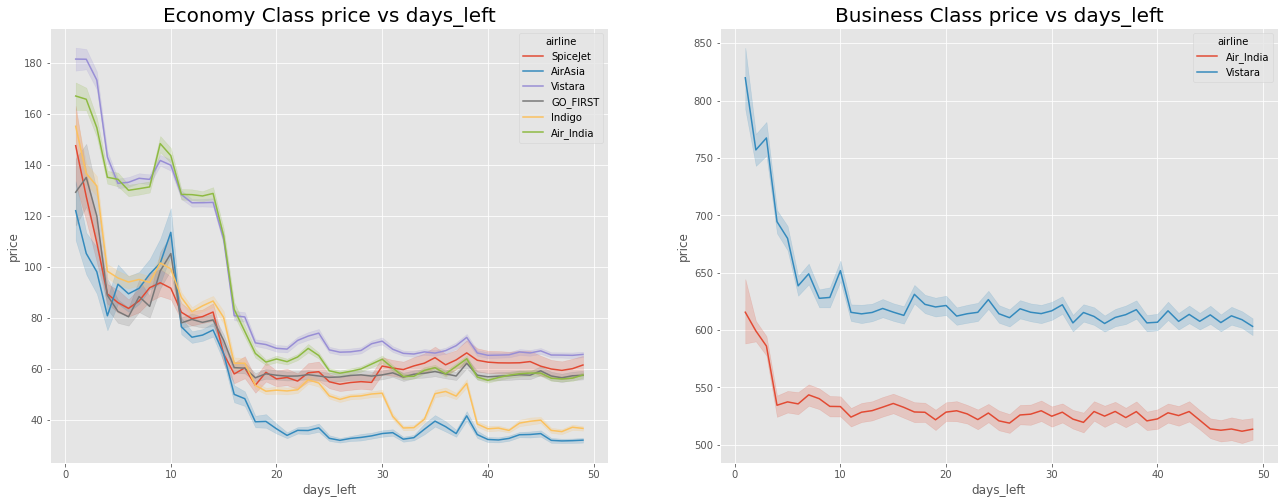

In [12]:
#Comparing prices between airlines and proving that days left is an important factor
fig, ax = plt.subplots(1,2,figsize=(22,8))
sns.lineplot(data=economy_df, x='days_left', y='price',hue='airline', ax=ax[0])
ax[0].set_title('Economy Class price vs days_left', fontsize=20)
sns.lineplot(data=business_df, x='days_left', y='price',hue='airline', ax=ax[1])
ax[1].set_title('Business Class price vs days_left', fontsize=20)

Text(0.5, 1.0, 'Business price for number of stops')

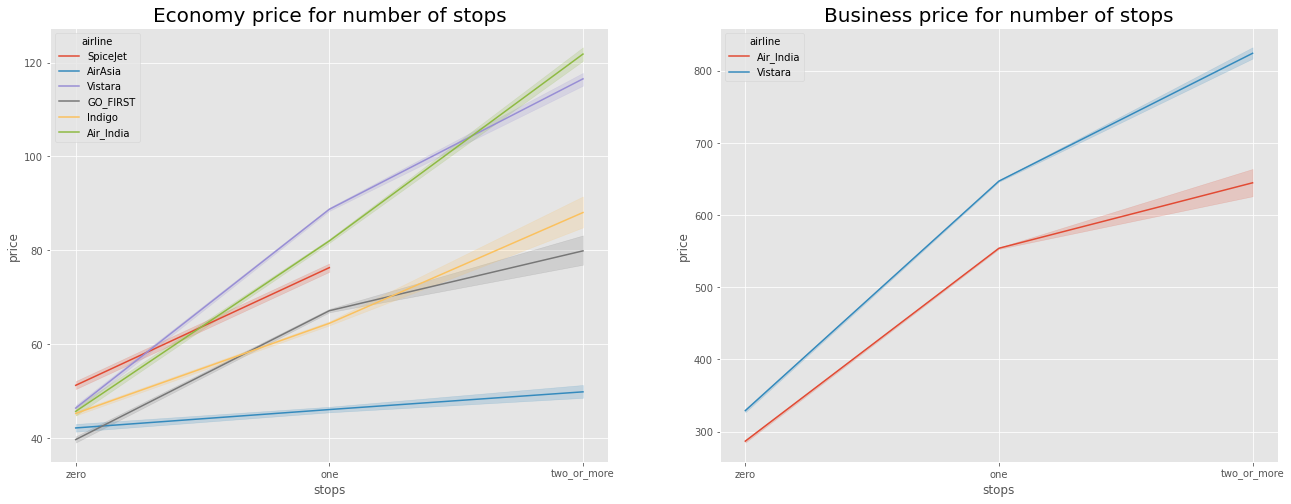

In [13]:
#Comparing prices between airlines and proving that number of stops is an important factor
fig, ax = plt.subplots(1,2,figsize=(22,8))
sns.lineplot(data=economy_df, x='stops', y='price',hue='airline', ax=ax[0])
ax[0].set_title('Economy price for number of stops', fontsize=20)
sns.lineplot(data=business_df, x='stops', y='price',hue='airline', ax=ax[1])
ax[1].set_title('Business price for number of stops', fontsize=20)

Text(0.5, 1.0, 'Business price for duration of flights')

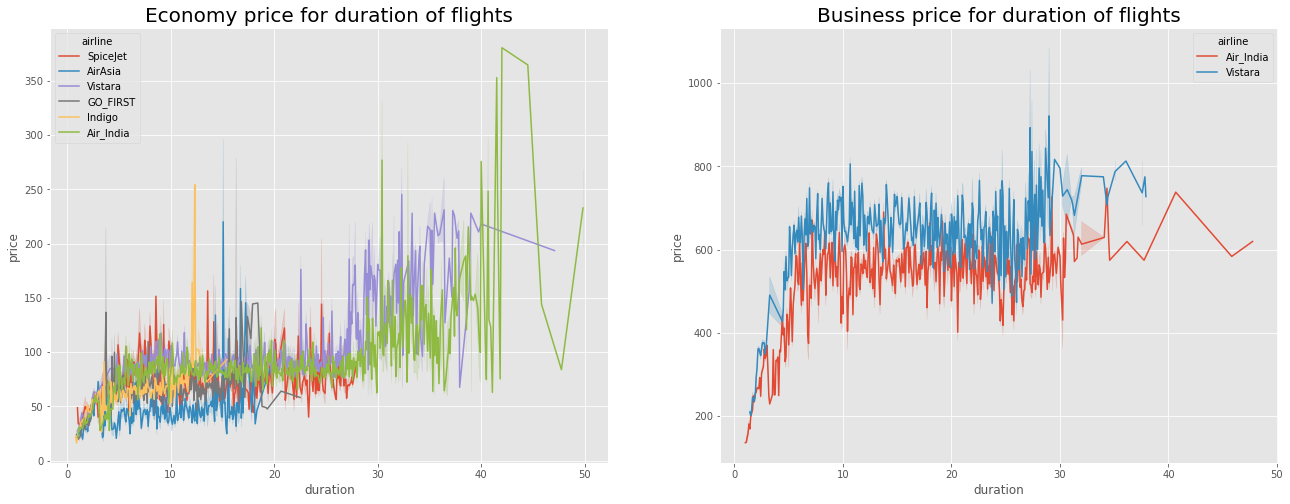

In [14]:
#Comparing prices between airlines and proving that duration of flight is an important factor
fig, ax = plt.subplots(1,2,figsize=(22,8))
sns.lineplot(data=economy_df, x='duration', y='price',hue='airline', ax=ax[0])
ax[0].set_title('Economy price for duration of flights', fontsize=20)
sns.lineplot(data=business_df, x='duration', y='price',hue='airline', ax=ax[1])
ax[1].set_title('Business price for duration of flights', fontsize=20)

As we can confirm from the plots the days left untill the flight, airline, number of stops and duration of the flight are important factors for determining the price. <br/><br/>
It makes sense that days left is a determining factor as airlines increase the price the closer to the flight date. It would be interesting to give a look into that in a different project due to unsufficient data in this project. <br/>
Furthermore, duration and number of stops, which are correlated due to obvious reasons, also are a determining factor for price. Most likely due to the fact that there is a more fuel consumption asociated as well as more hours payed in wages to aircrew staff.
<br/>
I would like to point out that it is interesting how Economy class price tickets depend much more on days left than Business class.

## Perform Linear Regression Analysis

- We have checked with the correlation map and several plots that no multicolinearity exists in the data. <br>
We are going to check for outliers. In order to comply with Linear Regression Models assumptions.

In [16]:
# Checking for outliers Economy
Q1 = economy_df['price'].quantile(0.25)
Q3 = economy_df['price'].quantile(0.75)
iqr = Q3 - Q1
upper_limit = Q3 + 1.5 * iqr
lower_limit = Q1 - 1.5 * iqr
outliers = economy_df[(economy_df['price'] > upper_limit)&(economy_df['price'] < lower_limit)]
# Checking for outliers in Business Class
Q1 = business_df['price'].quantile(0.25)
Q3 = business_df['price'].quantile(0.75)
iqr = Q3 - Q1
upper_limit = Q3 + 1.5 * iqr
lower_limit = Q1 - 1.5 * iqr
outliers = business_df[(business_df['price'] > upper_limit)&(business_df['price'] < lower_limit)]
print(outliers)

Empty DataFrame
Columns: [#, airline, flight, source_city, departure_time, stops, arrival_time, destination_city, class, duration, days_left, price]
Index: []


No outliers

### Linear Regression For Economy

In [17]:
# Isolate target variable
y = economy_df['price']

# Isolate target variables
x = econ_factorized_df.drop(['price'], axis=1)

In [18]:
# Split the data
x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size=0.25, random_state=42)

In [19]:
# Fit the data using linear Regression model
log_clf = LinearRegression().fit(x_train, y_train)

In [20]:
# Get predicitions
y_pred = log_clf.predict(x_test)

In [21]:
# Get the metrics
r2_metric = r2_score(y_test, y_pred)
print(' R2 Metric:  ' + str(r2_metric))
mae_metric = mean_absolute_error(y_test, y_pred)
print('MAE: ' + str(mae_metric))
rmse_metric = mean_squared_error(y_test, y_pred)
print('RMAE: ' + str(rmse_metric))

 R2 Metric:  0.4247831417198974
MAE: 23.34703263449564
RMAE: 1000.9799313295946


### Linear Regression for Business class

In [22]:
# Isolate target variable
y = business_df['price']

# Isolate target variables
x = bus_factorized_df.drop(['price'], axis=1)

In [23]:
# Split the data
x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size=0.25, random_state=42)

In [24]:
# Fit the Linear Regression model
log_clf = LinearRegression().fit(x_train, y_train)

In [25]:
# Get predicitions
y_pred = log_clf.predict(x_test)

In [26]:
# Get the metrics
r2_metric = r2_score(y_test, y_pred)
print(' R2 Metric:  ' + str(r2_metric))
mae_metric = mean_absolute_error(y_test, y_pred)
print('MAE: ' + str(mae_metric))
rmse_metric = mean_squared_error(y_test, y_pred)
print('RMAE: ' + str(rmse_metric))

 R2 Metric:  0.4631564861838403
MAE: 81.67733371973748
RMAE: 11536.360109868747


## Create  a Decision Tree model

### For Economy Class

In [27]:
# Isolate target and feature variables
y = econ_factorized_df['price'].copy()
x = econ_factorized_df.drop(['price'],axis=1)

In [28]:
# Split the data
x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size=0.25, random_state=42)

In [29]:
# Instantiate model
tree = DecisionTreeRegressor(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = { 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params,  cv=4)

In [31]:
tree1.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]})

In [32]:
# Check best parameters
tree1.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [34]:
y_pred = tree1.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error: 8.483728594728571
R-squared: 0.8109167989084201


Text(0.5, 1.0, 'Feature Importance (MDI)')

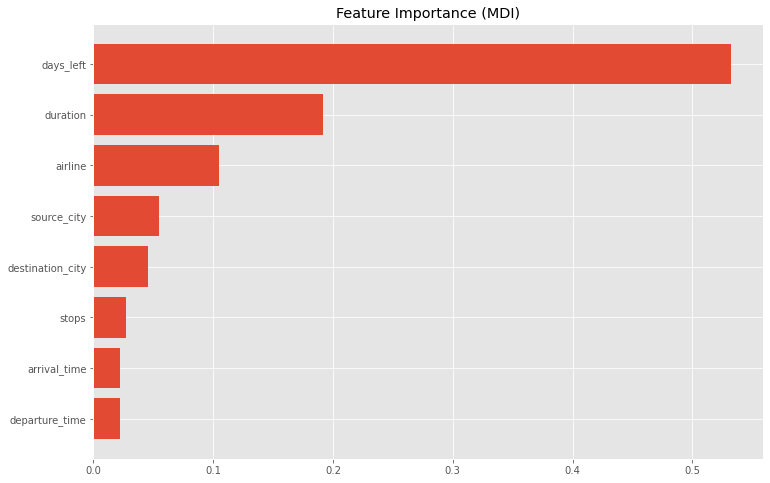

In [37]:
#Plot feature importance

# obtain feature importance
feature_importance = tree1.best_estimator_.feature_importances_
# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
feature_names = x.columns

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

### For Bsuiness Class

In [38]:
# Isolate target variable
y = bus_factorized_df['price'].copy()

# Isolate target variables
x = bus_factorized_df.drop(['price'], axis=1)

In [39]:
# Split the data
x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size=0.25, random_state=42)

In [40]:
# Instantiate model
tree = DecisionTreeRegressor(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = { 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params,  cv=4)

In [41]:
tree1.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]})

In [42]:
# Check best parameters
tree1.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [43]:
y_pred = tree1.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error: 25.220527804481737
R-squared: 0.8702766153364899


Text(0.5, 1.0, 'Feature Importance (MDI)')

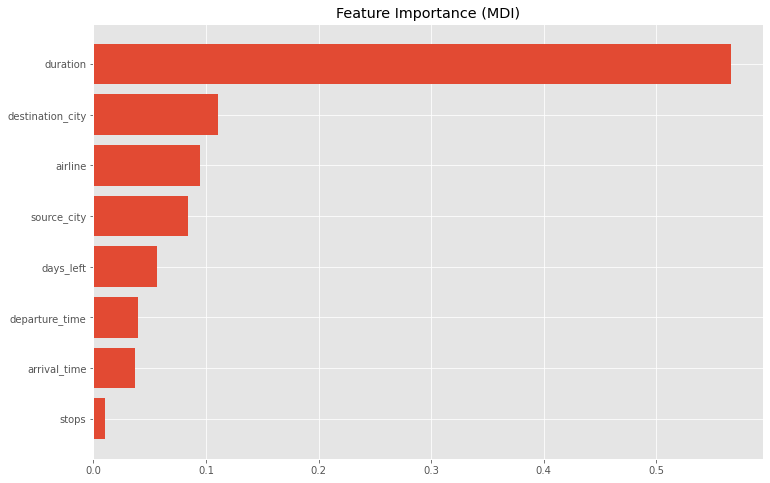

In [44]:
#Plot feature importance

# obtain feature importance
feature_importance = tree1.best_estimator_.feature_importances_
# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
feature_names = x.columns

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

## Create a Random forest model

### For Economy Class

In [35]:
# Isolate target variable
y = econ_factorized_df['price'].copy()

#Isolate features of interest
x = econ_factorized_df.copy()
x= econ_factorized_df.drop(['price'], axis=1)

In [36]:
#Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [38]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error: 6.863253461142596
R-squared: 0.8675351392186701


Text(0.5, 1.0, 'Feature Importance (MDI)')

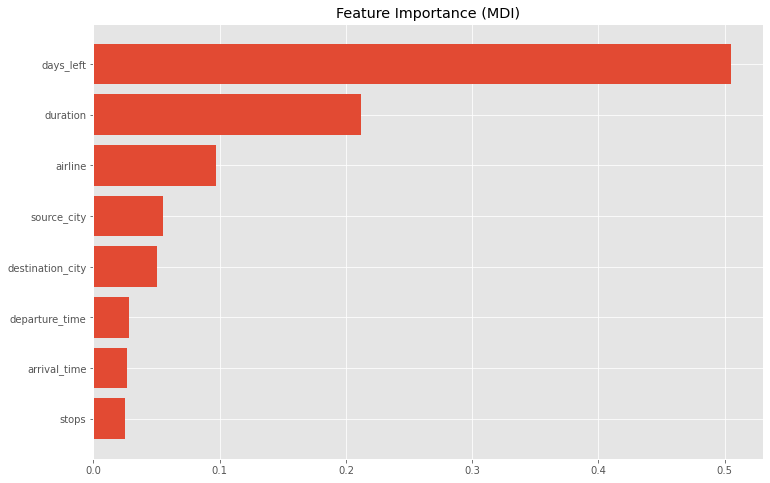

In [39]:
#Plot feature importance

# obtain feature importance
feature_importance = model.feature_importances_
# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
feature_names = x.columns

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

### For Business Class

In [96]:
# Isolate target variable
y = business_df['price']

# Isolate target variables
x = bus_factorized_df.drop(['price', '#'], axis=1)

In [97]:
#Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [98]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error: 19.011671899375372
R-squared: 0.9134193002630819


Text(0.5, 1.0, 'Feature Importance (MDI)')

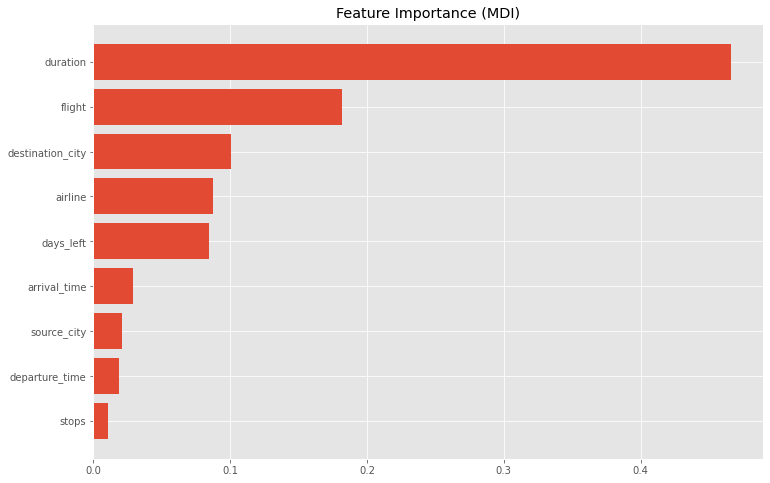

In [99]:
# obtain feature importance
feature_importance = model.feature_importances_

#Plot feature importance

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
feature_names = x.columns

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")